## 1. Requirements

In [1]:
import foolbox
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision.datasets import MNIST
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 2. MNIST model

In [2]:
class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        # mnist의 경우 28*28의 흑백이미지(input channel=1)이다.
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 5, padding=2)
        # feature map의 크기는 14*14가 된다
        # 첫번재 convolution layer에서 나온 output channel이 32이므로 2번째 input도 32
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 5, padding=2)
        # feature map의 크기는 7*7이 된다
        # fc -> fully connected, fc는 모든 weight를 고려해서 만들기 때문에 cnn에서는 locally connected를 이용하여 만든다.
        # nn.Linear에서는 conv를 거친 feature map을 1차원으로 전부 바꿔서 input을 한다. 이게 64*7*7
        self.fc1 = nn.Linear(64*7*7, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 64*7*7) # linear에 들어갈 수 있도록 reshape
        x = F.relu(self.fc1(x)) # fully connected에 relu 적용
        x = F.dropout(x, training=self.training) # 가중치 감소만으로는 overfit을 해결하기가 어려움, 그래서 뉴런의 연결을 임의로 삭제
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## 3. Deepfool attack

In [3]:
def deepfool_attack(model, device, test_loader):
    print("Attack Image!!")
    
    perturbed_images = []
    for image, label in test_loader:
        attack = foolbox.attacks.DeepFoolAttack(model)
        image_np = attack(image.numpy(), label.numpy())
        perturbed_image = torch.from_numpy(image_np)
        perturbed_images.append((perturbed_image, label))

    print("Attack Done!!")
    return perturbed_images

## 4. test function

In [4]:
def test(model, device, images):
    # Accuracy counter
    correct = 0
    adv_examples = []

    # test set의 모든 예제를 test한다
    for image, label in images:
        # cpu나 gpu로 데이터를 전송한다
        image, label = image.to(device), label.to(device)

        # Re-classify the perturbed image
        output = model(image)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == label.item():
            correct += 1
            if (len(adv_examples) < 5):
                adv_ex = image.squeeze().detach().cpu().numpy()
                adv_examples.append( (label.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = image.squeeze().detach().cpu().numpy()
                adv_examples.append( (label.item(), final_pred.item(), adv_ex) )

    # final_acc = correct/idx
    final_acc = correct/float(len(images))
    print("Test Accuracy = {} / {} = {}".format(correct, len(images), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

## 5. Load dataset and pretrained model, Set device

In [5]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
])

download_path = './data'
train_dataset = MNIST(download_path, transform=mnist_transform, train=True, download=True)
test_dataset = MNIST(download_path, transform=mnist_transform, train=False, download=True)

In [6]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
print("CUDA Available:", is_cuda)

CUDA Available: True


In [7]:
# pretrained_model: 이전에 training한 mnist 모델
pretrained_model = './model/mnist_um.pth'
df_defense_model = './model/mnist_deepfool_model.pth'

model_normal = MnistModel().to(device)
model_normal.load_state_dict(torch.load(pretrained_model, map_location='cpu'))
fmodel = foolbox.models.PyTorchModel(model_normal, bounds=(0, 1), num_classes=10)

model_df = MnistModel().to(device)
model_df.load_state_dict(torch.load(df_defense_model, map_location='cpu'))

/home/pksll325/anaconda3/envs/pytorch/lib/python3.6/site-packages/foolbox/models/pytorch.py:71: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"


<All keys matched successfully>

## 6. Run test

In [8]:
perturbed_images = deepfool_attack(fmodel, device, test_loader)

Attack Image!!
Attack Done!!


In [9]:
normal_accuracies = []
examples = []


print('Normal:')
acc, ex = test(model_normal, device, perturbed_images)
normal_accuracies.append(acc)
examples.append(ex)

Normal:
Test Accuracy = 3501 / 10000 = 0.3501


In [10]:
df_accuracies = []

print('Deepfool defense:')    
acc, ex = test(model_df, device, perturbed_images)
df_accuracies.append(acc)

Deepfool defense:
Test Accuracy = 4980 / 10000 = 0.498


# Results

## Accuracy

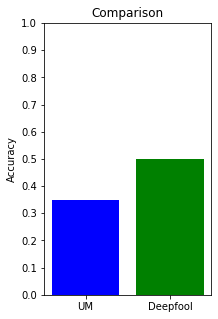

In [11]:
plt.figure(figsize=(3,5))
plt.bar(['UM'], normal_accuracies, label='UM', color='b')
plt.bar(['Deepfool'], df_accuracies, label='DF', color='g')
plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.title("Comparison")
plt.ylabel("Accuracy")
plt.show()

In [27]:
from torchvision.utils import save_image

for idx, (label, pred, image) in enumerate(examples[0]):
    #image = image.numpy()
    title = str(idx) + '_' + str(label) + '_' + str(pred) + '.png'
    image_t = torch.from_numpy(image)
    save_image(image_t, title)